# Classification of the MNIST handwritten digits using CNNs
In this notebook we will do the following steps in order:

1. Load and normalizing the MNIST training and test datasets using torchvision
2. Define a Neural Network (simple fully connected at first, CNN later)
3. Define a loss function
4. Train the network on the training split of MNIST
5. Test the network on the test split of MNIST



## Install Pytorch to Colab VM
[Pytorch](https://pytorch.org) is a deep learning framework that allows you to build, train and evaluate various deep learning models, such as CNNs that we are going to work with in this project. 

In [1]:
import os
import sys    
print("Python version: {}".format(sys.version_info[0]))

import warnings
warnings.filterwarnings('ignore') # to suppress unnecessary warnings

try:
    import torch
    print("PyTorch is already installed, good to go!") 
except:
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
    !pip install -q \
      http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl \
      torchvision
    print("Successfully installed PyTorch!")
    import torch

Python version: 3


## Some imports and setup

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt  # for plots
import numpy as np  # for working with numbers and arrays of numbers

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

import random
seed = 1
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
print("Setup is done!")

Setup is done!


# 1. Load MNIST data
Loading the data into your python script can be a tedious process. Luckily, PyTorch allows us to load the data using the torchvision.datasets classes. It has some of the popular datasets loading proccesses written for you, including the MNIST dataset.
The data will be downloaded to the mnist_dir folder on the virtual machine if you run this cell for the first time.
## Transforms
The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].
PyTorch Tensors are similar to NumPy’s ndarrays, with the addition being that Tensors can also be used on a GPU to accelerate computing.
## Iterating through the dataset
Let’s put this all together to create a dataset with composed transforms. Every time this dataset is sampled:

* An image is read from the file on the fly
* Transforms are applied on the read image
* We can iterate over the created dataset with a for i in range loop.

In [3]:
mnist_dir = 'datasets/MNIST' # the directory our data will be downloaded too

transformed_dataset = datasets.MNIST(mnist_dir, train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)) # normalizing to the [-1,1] range
                       ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample[0].size(), sample[1].size())

    if i == 3:
        break

Processing...
Done!
0 torch.Size([1, 28, 28]) torch.Size([])
1 torch.Size([1, 28, 28]) torch.Size([])
2 torch.Size([1, 28, 28]) torch.Size([])
3 torch.Size([1, 28, 28]) torch.Size([])


However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

* Batching the data - images can be processed in bulk instead of one-by-one
* Shuffling the data - this is a useful technique of rearranging the order of the images in which our training algorithm will pick images
* Load the data in parallel using multiprocessing workers.

`torch.utils.data.DataLoader` is an iterator which provides all these features.
In the code below we create 2 `DataLoader` objects, one for the training data, and one for the test data

To summarize, in order to load the data using PyTorch methods we need to:
1. Apply the necessary transforms to the image, in order to make it the same size as the rest and normalized
2. Create the `Dataset` object containing the methods to sample a training image
3. Create the `DataLoader` object for us to easier iterate over data

In [5]:
def load_MNIST(mnist_dir, batch_size, test_batch_size, kwargs):

  # Dataloader object is used to organize training data neatly into batches
  # it is a part of the PyTorch framework
  train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(mnist_dir, train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
  test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(mnist_dir, train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)
  
  return train_loader, test_loader


batch_size = 50 
test_batch_size = 100
mnist_dir = 'datasets/MNIST' # the directory our data will be downloaded too
train_loader, test_loader = load_MNIST(mnist_dir, batch_size, test_batch_size, kwargs)
print("The MNIST data is loaded successfully!")

The MNIST data is loaded successfully!


## Look at the data
We will sample a small subset of the training data to see what the MNIST data roughly looks like

One minibatch of MNIST data is a 4D array of shape torch.Size([50, 1, 28, 28])
1st dimension (50) is the number of images in the minibatch
2nd dimension (1) is the number of image channels
3rd and 4th dimensions (28, 28) are the spatial size of the image


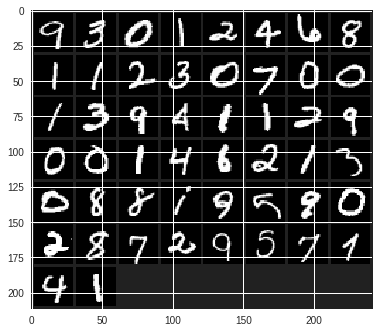

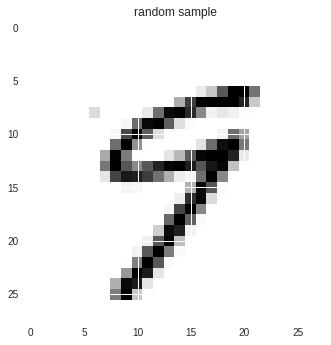

In [6]:
# this function is here to show an image
def imshow(img, title=None):
    npimg = img.numpy()
    mean = np.array([0.1307])
    std = np.array([0.3081])
    npimg = std * npimg + mean # unnormalize
    npimg = np.clip(npimg, 0, 1)
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = npimg.squeeze()
    plt.imshow(npimg)
    plt.show
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated 


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print("One minibatch of MNIST data is a 4D array of shape {}".format(images.shape))
print("1st dimension ({}) is the number of images in the minibatch".format(batch_size))
print("2nd dimension ({}) is the number of image channels".format(images.shape[1]))
print("3rd and 4th dimensions ({0}, {1}) are the spatial size of the image".format(*images.shape[-2:]))

# show images
imshow(torchvision.utils.make_grid(images))

# show one sample
for batch_idx, (data, target) in enumerate(train_loader):
  sample = data[0] # change number to any id in the batch 
  imshow(sample, 'random sample')
  break

# 2. Define the neural network

## Fully connecter with 1 layer
The pixels are represented as a 1D vector of size 784 and fed into a fully connected network with 10 output neurons
![alt text](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/d5222c6e3d15770a.png)
### Softmax 

We also use a softmax function to transfer scores (logits) into class probabilities. \\
Entries are normalized -> sum up to 1

![alt text](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/604a9797da2a48d7.png)

### Note:
The fully-connected layer can be constructed with a `nn.Linear` module, which accepts 2 parameters:

* `in_channels` - number of input neurons
* `out_channels` - number of output neurons
For example, when we have 784 input neurons and 10 output neurons we can initialize our module the following way:
```
nn.Linear(784,10)
```

In [0]:
class simpleFC(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        # declaring operations
        super().__init__() # calling the inint method of the superclass (nn.Module)
        self.fc1 = nn.Linear(input_size, num_classes) # fully-connected layer
    
    def forward(self, x):
        # defines the forward pass
        x = x.view(-1, 784) # here we represent a MNIST image as a vector of pixels
        # 784 is the total number of pixels in a 28 by 28 image
        out = self.fc1(x) # weighted sum of input and network weights -> Wx+b, b - bias
        return F.log_softmax(out, dim=1) # return activations after softmax layer
    
model = simpleFC().to(device)

Here we just defined the forward function. The backward function (where gradients are computed) is automatically defined for us using autograd. Any of the Tensor operations can be used in the forward function.

# 3. Define a Loss Function and an Optimizer
## Loss? How cross-entropy loss is calculated? 
Loss is a way to quantifying what it means to have a “good” classifier
![alt text](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/1d8fc59e6a674f1c.png) 

**Note!!!** In Pytorch obtaining log-probabilities in a neural network is easily achieved by adding a  `LogSoftmax`  layer in the last layer of your network and using `NLLLoss` (The negative log likelihood loss)
You may use `CrossEntropyLoss` instead, if you prefer not to add an extra layer.

## Optimizer
The simplest update rule used in practice is the Stochastic Gradient Descent (SGD). This method updates all the weights of the neural net after computing the loss on one batch of images. The SGD update rule, as well as other more complicated optimizers like Nesterov-SGD, Adam, RMSProp, etc, are implemented in the torch.optim module. All you need to do is to create an optimizer variable and call its `.step` method during training. This will automatically update the weights of your network after you have computed the gradients with the `loss.backward` call.

In [0]:
# this will be the function we use later to calculate the cross entropy loss
#loss_function = nn.CrossEntropyLoss() # use this instead if you don't use softmax activations
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # lr - learning rate

## How to choose your learning rate?

Hyperparameter - not-leranable parameter and picked manually in the begging of training \\
Try and see what works best \\

Check behavious: 
1. Simple_FC with lr = 0.01, 0.001, 0.0001
2. Complex_FC with lr = 0.01, 0.001, 0.0001
3. CNN with lr = 0.1, 0.01 

![alt text](http://cs231n.github.io/assets/nn3/learningrates.jpeg)

## What is momentum?
 - running average of previous updates! Small oscillations 
 
 `V = momentum*V + (1-momentum)*gradient_of_parameters`
 
![alt text](https://cdn-images-1.medium.com/max/1600/1*5-GPmnonHVQiIj2EPG3Fgw.png)

Without Momentum -> 

```
update = learning_rate * gradient_of_parameters
parameters = parameters - update

```

![alt text](https://qph.fs.quoracdn.net/main-qimg-7adad11c6ee947a96e917e2a8205392d)

With Momentum 
```
V = momentum*V + (1-momentum)*gradient_of_parameters
parameters = parameters - learning_rate * V

```

![alt text](https://deeplearning4j.org/img/updater_2.png)

# 4. Train the network

In [10]:
def train(model, device, train_loader, loss_function, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # data has a batch of images
        # target is a batch of corresponding training labels
        optimizer.zero_grad() # initialize all the gradients with zeros
        output = model(data) # compute the network's predictions for the batch of images
        loss = loss_function(output, target) # here we calculate the loss value
        loss.backward() # compute the gradients for all the weights of the network automatically!
        optimizer.step() # here we actually update the network's weights
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))         
print('Training method loaded!')

Training method loaded!


In [11]:
num_epochs = 5
for epoch in range(1, num_epochs + 1):
        train(model, device, train_loader, loss_function, optimizer, epoch)
print('Training finished')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.386618
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.619948
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.562826
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.383312
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.361996
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.414902
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.474092
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.264486
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.353208
Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.121874
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.311655
Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.218012
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.272649
Train Epoch: 2 [5000/60000 (8%)]	Loss: 0.429684
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.327304
Train Epoch: 2 [15000/60000 (25%)]	Loss: 0.403604
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.237556
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.395428
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.282789
Train Epoch: 2 [35000/60000 (58%)]	Loss: 0.309991
Train Epoch: 2

# 5. Test on the remaining 10000 images
here we have a method to calculate how well our trained network can work on the images that it has not seen during training.

In [12]:
def test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        if batch_idx % 10 == 0:
            print('[{}/{}]\t'
                  'Correct: {}\t'
                  'Total: {}\t'.format(
                batch_idx,
                len(test_loader),
                correct,
                total))
    if len(test_loader.dataset)==0:
        print("Error: test data have not been loaded correctly")
        return -1
    
    accuracy = 100.0 * correct / total

    print('Accuracy of the network on the test images: {:.3f}%; correct: {} out of {}'.format(
        accuracy, correct, total))
    
print("Test method is loaded successfully")    

Test method is loaded successfully


## Call the test function to get the accuracy of our model on the test data

In [0]:
test(model, device, test_loader)

[0/100]	Correct: 91	Total: 100	
[10/100]	Correct: 1010	Total: 1100	
[20/100]	Correct: 1922	Total: 2100	
[30/100]	Correct: 2834	Total: 3100	
[40/100]	Correct: 3752	Total: 4100	
[50/100]	Correct: 4667	Total: 5100	
[60/100]	Correct: 5601	Total: 6100	
[70/100]	Correct: 6535	Total: 7100	
[80/100]	Correct: 7456	Total: 8100	
[90/100]	Correct: 8383	Total: 9100	
Accuracy of the network on the test images: 92.080%; correct: 9208 out of 10000


## How does optimization work?
![alt text](https://cdn-images-1.medium.com/max/1600/1*bl1EuPH_XEGvMcMW6ZloNg.jpeg)

# Now let's try other networks

## Convolutional net with 2 conv layers
### Conv2d
A convolutional layer in PyTorch can be created using the nn.Conv2d function.
Here are its some essential parameters:
1. in_channels -  depth of the input (D1)
2. out_channels - depth of the output (D2)
3. kernel_size - defines both height and with of the filter (F)
4. padding - set to 0 by default, which means no zero padding
5. stride - set to 1 by default

Example of initializing the conv2d module:

```
in_channels = 1
out_channels = 10
kernel_size = 5
nn.conv2d(in_channels, out_channels, kernel_size)
```
The function then can be called on the 4D input tensor of size nSamples x nChannels x Height x Width, which is one batch (nSamples) of images. The call happens in the ```forward``` method of our model 
### Max pooling
It is common to periodically insert a Pooling layer in-between successive Conv layers in a ConvNet architecture. Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting.

This is mainly done to fight overfitting and to lower the computational cost by reducing the number of parameters to learn. This also provides a basic translation invariance to the internal representation.

Max pooling is done by applying a max filter to (usually) non-overlapping subregions of the initial representation. The most commonly used is the 2x2 max filter applied with a stride S = 2:
![alt text](http://cs231n.github.io/assets/cnn/maxpool.jpeg)

### Note! 
PyTorch `torch.nn.functional.max_pool2d` function has 2 required parameters:
* `input` - the input image or feature map
* `kernel_size` - the size of the max filter (we will use 2)


### In the following section we can check the shapes of different feature maps starting from the input 4D tensor (nSamples x nChannels x Height x Width) and going all the way to the output activations.

In [14]:
class exampleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # first convolutional layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # second convolutional layer
        self.fc1 = nn.Linear(20*4*4, 10) # fully connected layer

    def forward(self, x):
        print("Original input size:\t {}".format(x.shape))
        x = self.conv1(x)
        print("Size after conv1:\t {}".format(x.shape))
        x = F.max_pool2d(x, 2)
        print("Size after max pool 1:\t {}".format(x.shape))
        x = F.relu(x)
        x = self.conv2(x)
        print("Size after conv2:\t {}".format(x.shape))
        x = F.max_pool2d(x, 2)
        print("Size after max pool 2:\t {}".format(x.shape))
        x = F.relu(x)
        x = x.view(-1, 16*20)
        print("Size before fc1:\t {}".format(x.shape))
        x = self.fc1(x)
        print("Size after fc1:\t\t {}".format(x.shape))
        return F.log_softmax(x, dim=1)   
    
example_model = exampleCNN().to(device)

batch = torch.stack((sample,)*1, 0) # just one image in a batch for example
batch.shape
example_model(batch)

Original input size:	 torch.Size([1, 1, 28, 28])
Size after conv1:	 torch.Size([1, 10, 24, 24])
Size after max pool 1:	 torch.Size([1, 10, 12, 12])
Size after conv2:	 torch.Size([1, 20, 8, 8])
Size after max pool 2:	 torch.Size([1, 20, 4, 4])
Size before fc1:	 torch.Size([1, 320])
Size after fc1:		 torch.Size([1, 10])


tensor([[-2.7785, -2.1833, -2.3476, -2.7450, -2.3958, -2.4470, -1.8635, -2.0824,
         -2.5188, -2.0605]], grad_fn=<LogSoftmaxBackward>)

### 2b. Define a CNN network
Now let's rewrite the same network without the ```print``` calls, so that they won't clutter our log when we are doing training

In [0]:
class simpleCNN(nn.Module):
    def __init__(self):
        super(simpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # first convolutional layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # second convolutional layer
        self.fc1 = nn.Linear(320, 10) # fully connected layer, 
        # why the first parameter is set to 320??? Think about it

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)   
    
cnn_model = simpleCNN().to(device) 

### 3b. Define the Loss and optimizer
### 4b. Train the network

In [0]:
loss_function = nn.NLLLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9) # lr - learning rate
num_epochs = 5
for epoch in range(1, num_epochs + 1):
        train(cnn_model, device, train_loader, loss_function, optimizer, epoch)
print('Training finished')        

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297239
Train Epoch: 1 [5000/60000 (8%)]	Loss: 1.346905
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.402406
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.345681
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.372023
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.188687
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.135336
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.345981
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.091861
Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.178510
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.101380
Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.122395
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.227132
Train Epoch: 2 [5000/60000 (8%)]	Loss: 0.184611
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.145423
Train Epoch: 2 [15000/60000 (25%)]	Loss: 0.179858
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.128512
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.059347
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.033392
Train Epoch: 2 [35000/60000 (58%)]	Loss: 0.104461
Train Epoch: 2

### 5b. and test it to get the final accuracy

In [0]:
test(cnn_model, device, test_loader)

[0/100]	Correct: 98	Total: 100	
[10/100]	Correct: 1085	Total: 1100	
[20/100]	Correct: 2070	Total: 2100	
[30/100]	Correct: 3056	Total: 3100	
[40/100]	Correct: 4037	Total: 4100	
[50/100]	Correct: 5024	Total: 5100	
[60/100]	Correct: 6004	Total: 6100	
[70/100]	Correct: 6984	Total: 7100	
[80/100]	Correct: 7968	Total: 8100	
[90/100]	Correct: 8956	Total: 9100	
Accuracy of the network on the test images: 98.410%; correct: 9841 out of 10000


## [Optional] Your beast network that will get more than 99% accuracy on the test split
Your code here! Modify the method below. You can start with the suggested code or rewrite your own.

In [0]:
class CNN(nn.Module):
    def __init__(self):
        ########################################################################
        # modify code here:
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # first convolutional layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # second convolutional layer
        self.fc1 = nn.Linear(320, 50) # fully connected layer 1
        self.fc2 = nn.Linear(50, 10) # fully connected layer 2
        ########################################################################

    def forward(self, x):
        ########################################################################
        # modify code here:
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        ########################################################################
        return F.log_softmax(x, dim=1)
    
cnn_model_2 = CNN().to(device)    

### 3c. Define a Loss and an Optimizer
### 4c. Train the network

In [0]:
loss_function = nn.NLLLoss()
optimizer = optim.SGD(cnn_model_2.parameters(), lr=0.001, momentum=0.9) # lr - learning rate
num_epochs = 5
for epoch in range(1, num_epochs + 1):
        train(cnn_model_2, device, train_loader, loss_function, optimizer, epoch)
print('Training finished') 

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298540
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.135333
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.657676
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.887301
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.003688
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.896496
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.069690
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.728462
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.427889
Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.543398
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.496777
Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.387470
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.296737
Train Epoch: 2 [5000/60000 (8%)]	Loss: 0.328595
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.374528
Train Epoch: 2 [15000/60000 (25%)]	Loss: 0.238472
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.252362
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.192033
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.274210
Train Epoch: 2 [35000/60000 (58%)]	Loss: 0.145280
Train Epoch: 2

### 5c. and test it

In [0]:
test(cnn_model_2, device, test_loader)

[0/100]	Correct: 99	Total: 100	
[10/100]	Correct: 1076	Total: 1100	
[20/100]	Correct: 2062	Total: 2100	
[30/100]	Correct: 3045	Total: 3100	
[40/100]	Correct: 4025	Total: 4100	
[50/100]	Correct: 5000	Total: 5100	
[60/100]	Correct: 5975	Total: 6100	
[70/100]	Correct: 6962	Total: 7100	
[80/100]	Correct: 7942	Total: 8100	
[90/100]	Correct: 8922	Total: 9100	
Accuracy of the network on the test images: 98.040%; correct: 9804 out of 10000
